# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

delphesDir = os.path.abspath("../../DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

sys.path.append('../../')
sys.path.append('../../ATLAS-SUSY-2016-08')
from helper import getLLPs,getModelDict,getUserInfo,getEventNorm,getHSCPCandidates

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

colors = sns.color_palette('Paired')

Welcome to JupyROOT 6.30/06


Warning in <TFile::Init>: no StreamerInfo found in /home/lessa/LLP-CDFO/DelphesLLP/Pythia8Dict_rdict.pcm therefore preventing schema evolution when reading this file. The file was produced with version 6.32/00 of ROOT.
Warning in <TFile::Init>: no StreamerInfo found in /home/lessa/LLP-CDFO/DelphesLLP/ClassesDict_rdict.pcm therefore preventing schema evolution when reading this file. The file was produced with version 6.32/00 of ROOT.
Warning in <TFile::Init>: no StreamerInfo found in /home/lessa/LLP-CDFO/DelphesLLP/ExRootAnalysisDict_rdict.pcm therefore preventing schema evolution when reading this file. The file was produced with version 6.32/00 of ROOT.
Warning in <TFile::Init>: no StreamerInfo found in /home/lessa/LLP-CDFO/DelphesLLP/ModulesDict_rdict.pcm therefore preventing schema evolution when reading this file. The file was produced with version 6.32/00 of ROOT.
Warning in <TFile::Init>: no StreamerInfo found in /home/lessa/LLP-CDFO/DelphesLLP/FastJetDict_rdict.pcm therefore pr

### Load Recast Data

In [2]:
inputFiles = ['../../eventData/cdfo_481.38_450.00_tau_2.85e-02_delphes_events.root',
              '../../eventData/cdfo_808.00_800.00_tau_9.81e-01_delphes_events.root']

labelsDict = {}
for f in inputFiles:
    bannerFile = 'run_01_%s_banner.txt' %(os.path.basename(f).replace('_delphes_events.root',''))
    bannerFile = os.path.join(os.path.dirname(f),bannerFile)
    modelDict = getModelDict(f,model='sbottom',bannerFile=bannerFile)
    labelsDict[f] = r'$m_{Y} = %1.0f$ GeV, $m_{X} = %1.0f$ GeV, $c \tau = %1.2f$ cm'%(modelDict['mLLP'],modelDict['mLSP'],modelDict['tau_ns']*30)


mLLP =  481.38
width (GeV) =  2.309474e-14
tau (ns) =  0.028499996103008733
mLLP =  808.0
width (GeV) =  6.70948e-16
tau (ns) =  0.9810000178851417


In [3]:
weights = {f : [] for f in inputFiles}
track_length = {f : [] for f in inputFiles}
lumi = 1.0
nCharged = {f : 0 for f in inputFiles}
nLLP = {f : 0 for f in inputFiles}
for inputFile in inputFiles:
    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    userInfo = getUserInfo(tree,inputFile)
    norm = getEventNorm(userInfo,False,nevts,nevts)

    for ievt in range(nevts):
        tree.GetEntry(ievt)   
        weightPB = tree.Event.At(0).Weight/nevts*norm     
        ns = weightPB*1e3*lumi # number of signal events
        
        llps = getLLPs(tree.bsm,tree.bsmDirectDaughters,tree.bsmFinalDaughters,tree.bsmMothers)
        nLLP[inputFile] += len(llps)
        llps = getHSCPCandidates(llps)
        nCharged[inputFile] += len(llps)


        if len(llps) == 0:
            continue
        llpSel = np.random.choice(llps)
        track_length[inputFile].append(min(1e5,np.sqrt(llpSel.r_decay**2 + llpSel.z_decay**2)))
        weights[inputFile].append(ns)        
    f.Close()


In [4]:
totalweightPB = {}
for f,w in weights.items():
    print(f)
    totalweightPB[f] = np.array(w).sum()
    print('Fraction of charged:',nCharged[f]/nLLP[f])

../../eventData/cdfo_481.38_450.00_tau_2.85e-02_delphes_events.root
Fraction of charged: 0.4449531737773153
../../eventData/cdfo_808.00_800.00_tau_9.81e-01_delphes_events.root
Fraction of charged: 0.44446539525194845


### Plot Jet Distributions

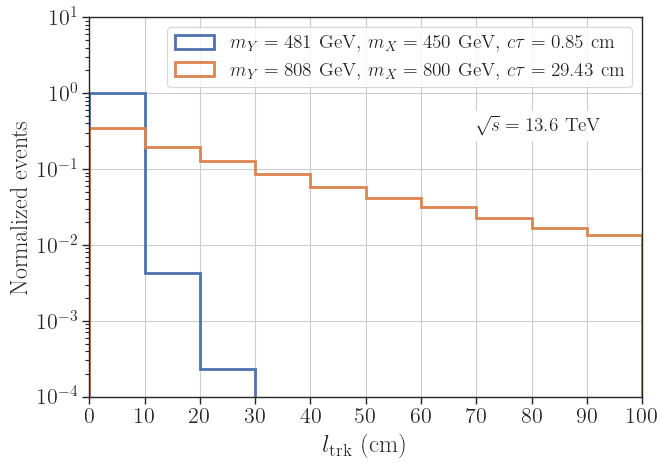

In [11]:
colors = sns.color_palette('deep')
fig = plt.figure(figsize=(7,5))
lbins = np.arange(0.,110.,10.0)
f = inputFiles[0]

x = np.array(track_length[f])/10.0
w = np.array(weights[f])/totalweightPB[f]
h1,_,_ = plt.hist(x,weights=w,label=labelsDict[f],histtype='step',
                  linewidth=2,bins=lbins,density=False,color=colors[0])



f = inputFiles[1]
x = np.array(track_length[f])/10.0
w = np.array(weights[f])/totalweightPB[f]
h2,_,_ = plt.hist(x,weights=w,label=labelsDict[f],histtype='step',
                  linewidth=2,bins=lbins,density=False,color=colors[1])

plt.text(0.7,0.7,r'$\sqrt{s} = 13.6$ TeV',fontsize=14,
         bbox=dict(facecolor='white', edgecolor='none'),transform = plt.gca().transAxes)



plt.legend(fontsize=14)
plt.yscale('log')
plt.xlim(0.,100.)
plt.ylim(1e-4,10)
plt.xticks(np.arange(0.,110.,10.))
plt.grid()

plt.xlabel(r'$l_{\rm trk}$ (cm)',fontsize=18)
plt.ylabel('Normalized events')

plt.tight_layout()
plt.savefig('trackLength_13.6TeV.png')
plt.show()